# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [15]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torchvision import transforms
% matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [33]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                                std=[0.20, 0.20, 0.20])
                       ])
                       )
data_test = dset.SVHN('./data/', split='test',
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])
                      ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [17]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [18]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)


# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [19]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [36]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

        if scheduler:
            scheduler.step()

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()  # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    overall, correct = 0, 0

    for _, (x, y) in enumerate(loader):
        prediction = model(x)
        prediction_indicies = torch.argmax(prediction, 1)
        correct += torch.sum(prediction_indicies == y)
        overall += y.shape[0]

    return correct / overall


loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.126023, Train accuracy: 0.716309, Val accuracy: 0.724592
Average loss: 1.111414, Train accuracy: 0.720199, Val accuracy: 0.727391
Average loss: 1.095578, Train accuracy: 0.727383, Val accuracy: 0.731281


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [21]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(Flattener(),
                         nn.Linear(3 * 32 * 32, 100),
                         nn.ReLU(inplace=True),
                         nn.Linear(100, 100),
                         nn.ReLU(inplace=True),
                         nn.Linear(100, 10),
                         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.181534, Train accuracy: 0.194178, Val accuracy: 0.219234
Average loss: 2.008649, Train accuracy: 0.275074, Val accuracy: 0.328169
Average loss: 1.797384, Train accuracy: 0.382486, Val accuracy: 0.396628
Average loss: 1.703789, Train accuracy: 0.420145, Val accuracy: 0.431097
Average loss: 1.675805, Train accuracy: 0.436576, Val accuracy: 0.432667


Добавьте слой с Batch Normalization

In [22]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(Flattener(),
                         nn.Linear(3 * 32 * 32, 100),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(100),
                         nn.Linear(100, 100),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(100),
                         nn.Linear(100, 10),
                         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.901412, Train accuracy: 0.398526, Val accuracy: 0.539485
Average loss: 1.499346, Train accuracy: 0.595843, Val accuracy: 0.637158
Average loss: 1.331533, Train accuracy: 0.652237, Val accuracy: 0.680568
Average loss: 1.233344, Train accuracy: 0.680681, Val accuracy: 0.703570
Average loss: 1.165801, Train accuracy: 0.699621, Val accuracy: 0.705003


Добавьте уменьшение скорости обучения по ходу тренировки.

In [26]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(Flattener(),
                         nn.Linear(3 * 32 * 32, 100),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(100),
                         nn.Linear(100, 100),
                         nn.ReLU(inplace=True),
                         nn.BatchNorm1d(100),
                         nn.Linear(100, 10),
                         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5,
                                                       scheduler=scheduler)

Average loss: 1.911192, Train accuracy: 0.384944, Val accuracy: 0.550201
Average loss: 1.482616, Train accuracy: 0.598864, Val accuracy: 0.639547
Average loss: 1.324449, Train accuracy: 0.657219, Val accuracy: 0.673538
Average loss: 1.258401, Train accuracy: 0.678224, Val accuracy: 0.697427
Average loss: 1.209421, Train accuracy: 0.691892, Val accuracy: 0.700771


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [46]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()  # Evaluation mode

    val_subset_sampler = SubsetSampler(indices)
    predictions = []
    ground_truth = []

    val_subset_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_subset_sampler)
    for (x, y) in val_subset_loader:
        predictions += torch.argmax(model(x), 1)
        ground_truth += y

    return predictions, ground_truth


# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

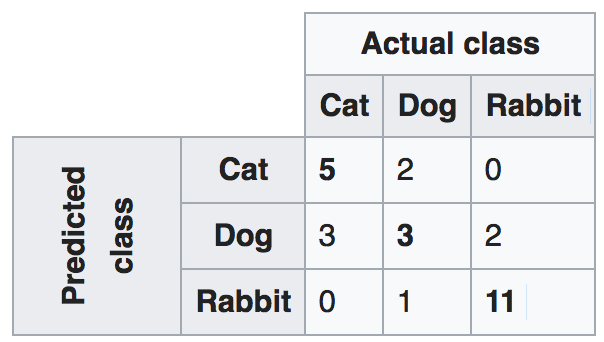

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

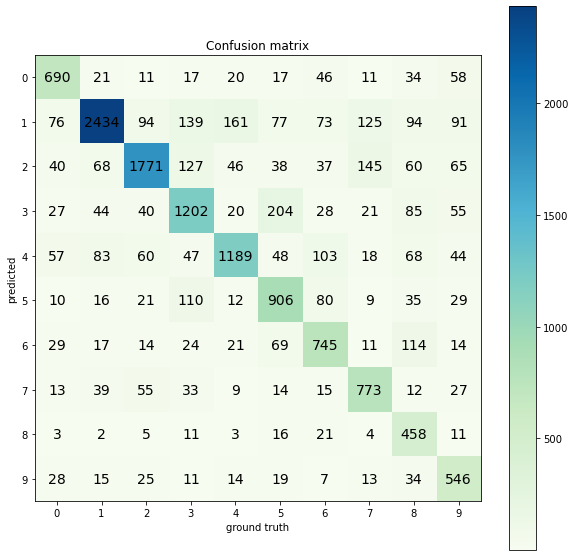

In [49]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10, 10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')


def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """

    confusion_matrix = np.zeros((10, 10), int)
    for pred, gt in zip(predictions, ground_truth):
        confusion_matrix[pred][gt] += 1

    return confusion_matrix


confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

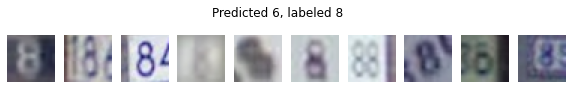

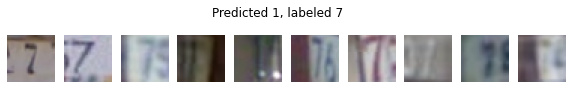

In [67]:
data_train_images = dset.SVHN('./data/', split='train')


def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10, 1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1, to_show, i + 1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)


def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    predictions = np.array(predictions)
    groud_truth = np.array(groud_truth)
    mask = (predictions == predicted_class) & (groud_truth == gt_class)
    images_slice = val_indices[mask]
    visualize_images(images_slice, data, f"Predicted {predicted_class}, labeled {gt_class}")


visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [77]:
num_epochs = 10
optimizer_funcs = [optim.Adadelta, optim.Adam]
hidden_layer_sizes = [100, 200]
leraning_rates = [1e-3, 1e-4]
weight_decays = [1e-1, 1e-2]
gammas = [0.9, 0.5, 0.1]

best_model = None
best_accuracy = 0
best_params = None

for lr in leraning_rates:
    for wd in weight_decays:
        for optimizer_func in optimizer_funcs:
            for hls in hidden_layer_sizes:
                for gamma in gammas:
                    print(
                        f"Trying model with params:\n\tlearning rate={lr}\n\tweight decay={wd}\n\toptimizer={type(optimizer)}\n\thidden layer size={hls}\n\tgamma={gamma}")
                    nn_model = nn.Sequential(
                        Flattener(),
                        nn.Linear(3 * 32 * 32, hls),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(hls),
                        nn.Linear(hls, hls),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(hls),
                        nn.Linear(hls, 10))
                    nn_model.type(torch.FloatTensor)
                    optimizer = optimizer_func(nn_model.parameters(), lr=lr, weight_decay=wd)
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
                    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss,
                                                                           optimizer, num_epochs, scheduler=scheduler)

                    cur_accuracy = val_history[-1]
                    if cur_accuracy > best_accuracy:
                        best_accuracy = cur_accuracy
                        best_model = nn_model
                        best_params = [lr, wd, optimizer_func, hls]

                print("\n\n")

print(f"Best validation accuracy = {best_accuracy} achieved with params={best_params}")

Trying model with params:
	learning rate=0.001
	weight decay=0.1
	optimizer=<class 'torch.optim.adadelta.Adadelta'>
	hidden layer size=100
	gamma=0.9
Average loss: 2.308632, Train accuracy: 0.155342, Val accuracy: 0.214320
Average loss: 2.104486, Train accuracy: 0.271525, Val accuracy: 0.325097
Average loss: 1.986747, Train accuracy: 0.348719, Val accuracy: 0.367006
Average loss: 1.922296, Train accuracy: 0.388083, Val accuracy: 0.404751
Average loss: 1.875755, Train accuracy: 0.415384, Val accuracy: 0.428503
Average loss: 1.847341, Train accuracy: 0.435570, Val accuracy: 0.445499
Average loss: 1.826216, Train accuracy: 0.448606, Val accuracy: 0.451095
Average loss: 1.814058, Train accuracy: 0.454578, Val accuracy: 0.460310
Average loss: 1.803172, Train accuracy: 0.460772, Val accuracy: 0.461880
Average loss: 1.797302, Train accuracy: 0.463946, Val accuracy: 0.470139
Trying model with params:
	learning rate=0.001
	weight decay=0.1
	optimizer=<class 'torch.optim.adadelta.Adadelta'>
	hid

Average loss: 1.821162, Train accuracy: 0.419855, Val accuracy: 0.406662
Average loss: 1.807697, Train accuracy: 0.424069, Val accuracy: 0.438810
Average loss: 1.751076, Train accuracy: 0.450295, Val accuracy: 0.428025
Average loss: 1.745504, Train accuracy: 0.451660, Val accuracy: 0.467477
Average loss: 1.702816, Train accuracy: 0.471044, Val accuracy: 0.463177
Average loss: 1.693842, Train accuracy: 0.473603, Val accuracy: 0.483448
Average loss: 1.670713, Train accuracy: 0.484131, Val accuracy: 0.490820
Average loss: 1.662832, Train accuracy: 0.487698, Val accuracy: 0.486247
Trying model with params:
	learning rate=0.001
	weight decay=0.1
	optimizer=<class 'torch.optim.adam.Adam'>
	hidden layer size=200
	gamma=0.5
Average loss: 1.712970, Train accuracy: 0.434358, Val accuracy: 0.452119
Average loss: 1.807094, Train accuracy: 0.419769, Val accuracy: 0.344482
Average loss: 1.841060, Train accuracy: 0.410350, Val accuracy: 0.424340
Average loss: 1.823882, Train accuracy: 0.417739, Val a

Average loss: 0.792366, Train accuracy: 0.762430, Val accuracy: 0.780220
Average loss: 0.772999, Train accuracy: 0.767379, Val accuracy: 0.783155
Average loss: 0.736039, Train accuracy: 0.779596, Val accuracy: 0.786909
Average loss: 0.725687, Train accuracy: 0.783282, Val accuracy: 0.793325
Trying model with params:
	learning rate=0.001
	weight decay=0.01
	optimizer=<class 'torch.optim.adam.Adam'>
	hidden layer size=100
	gamma=0.5
Average loss: 1.429408, Train accuracy: 0.538972, Val accuracy: 0.598594
Average loss: 1.173340, Train accuracy: 0.629731, Val accuracy: 0.631151
Average loss: 1.023010, Train accuracy: 0.685374, Val accuracy: 0.703228
Average loss: 0.986804, Train accuracy: 0.694349, Val accuracy: 0.705617
Average loss: 0.890450, Train accuracy: 0.728867, Val accuracy: 0.735581
Average loss: 0.863895, Train accuracy: 0.736819, Val accuracy: 0.754829
Average loss: 0.796909, Train accuracy: 0.760571, Val accuracy: 0.769163
Average loss: 0.780698, Train accuracy: 0.765826, Val 

Average loss: 2.407973, Train accuracy: 0.112070, Val accuracy: 0.121766
Average loss: 2.347710, Train accuracy: 0.129526, Val accuracy: 0.138762
Average loss: 2.315342, Train accuracy: 0.144712, Val accuracy: 0.151525
Average loss: 2.296587, Train accuracy: 0.155342, Val accuracy: 0.155416
Average loss: 2.284335, Train accuracy: 0.163464, Val accuracy: 0.160467
Average loss: 2.276269, Train accuracy: 0.167508, Val accuracy: 0.168248
Average loss: 2.270625, Train accuracy: 0.170870, Val accuracy: 0.170500
Average loss: 2.266438, Train accuracy: 0.171860, Val accuracy: 0.170842
Average loss: 2.264283, Train accuracy: 0.174436, Val accuracy: 0.172411
Average loss: 2.262431, Train accuracy: 0.176740, Val accuracy: 0.172138
Trying model with params:
	learning rate=0.0001
	weight decay=0.1
	optimizer=<class 'torch.optim.adadelta.Adadelta'>
	hidden layer size=200
	gamma=0.1
Average loss: 2.419300, Train accuracy: 0.102583, Val accuracy: 0.113644
Average loss: 2.359734, Train accuracy: 0.1177

Average loss: 2.316790, Train accuracy: 0.137682, Val accuracy: 0.138762
Average loss: 2.311872, Train accuracy: 0.138621, Val accuracy: 0.142379
Average loss: 2.307715, Train accuracy: 0.142392, Val accuracy: 0.141492
Average loss: 2.305641, Train accuracy: 0.143995, Val accuracy: 0.141356
Average loss: 2.304482, Train accuracy: 0.143603, Val accuracy: 0.142857
Trying model with params:
	learning rate=0.0001
	weight decay=0.01
	optimizer=<class 'torch.optim.adadelta.Adadelta'>
	hidden layer size=100
	gamma=0.1
Average loss: 2.394880, Train accuracy: 0.106269, Val accuracy: 0.115624
Average loss: 2.351992, Train accuracy: 0.121216, Val accuracy: 0.126886
Average loss: 2.326396, Train accuracy: 0.132273, Val accuracy: 0.135144
Average loss: 2.312799, Train accuracy: 0.140225, Val accuracy: 0.143813
Average loss: 2.302188, Train accuracy: 0.145719, Val accuracy: 0.147703
Average loss: 2.295415, Train accuracy: 0.149473, Val accuracy: 0.149341
Average loss: 2.290266, Train accuracy: 0.153

Average loss: 0.517864, Train accuracy: 0.850084, Val accuracy: 0.832503
Trying model with params:
	learning rate=0.0001
	weight decay=0.01
	optimizer=<class 'torch.optim.adam.Adam'>
	hidden layer size=200
	gamma=0.1
Average loss: 1.374358, Train accuracy: 0.579616, Val accuracy: 0.677565
Average loss: 0.943117, Train accuracy: 0.715114, Val accuracy: 0.736537
Average loss: 0.757466, Train accuracy: 0.772293, Val accuracy: 0.786567
Average loss: 0.697600, Train accuracy: 0.791369, Val accuracy: 0.794417
Average loss: 0.621357, Train accuracy: 0.817152, Val accuracy: 0.812846
Average loss: 0.595816, Train accuracy: 0.825479, Val accuracy: 0.819398
Average loss: 0.557511, Train accuracy: 0.837406, Val accuracy: 0.826701
Average loss: 0.547287, Train accuracy: 0.840852, Val accuracy: 0.829500
Average loss: 0.527367, Train accuracy: 0.847746, Val accuracy: 0.829704
Average loss: 0.520741, Train accuracy: 0.850118, Val accuracy: 0.834346



Best validation accuracy = 0.8428093791007996 achi

In [78]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8254
